In [98]:
# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')


# Handle table-like data and matrices :
import numpy as np
import pandas as pd
import math 
import itertools
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno

# Modelling Helpers :
#from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score

# Deep Learning Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical

In [99]:
train = pd.read_csv('fashion-mnist_train.csv')
df = train.copy()

In [100]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
df.label.unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

In [102]:
# Train
df.isnull().any().sum()

0

In [103]:
# Mapping Classes
clothing = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

In [104]:
clothing[0]

'T-shirt/top'

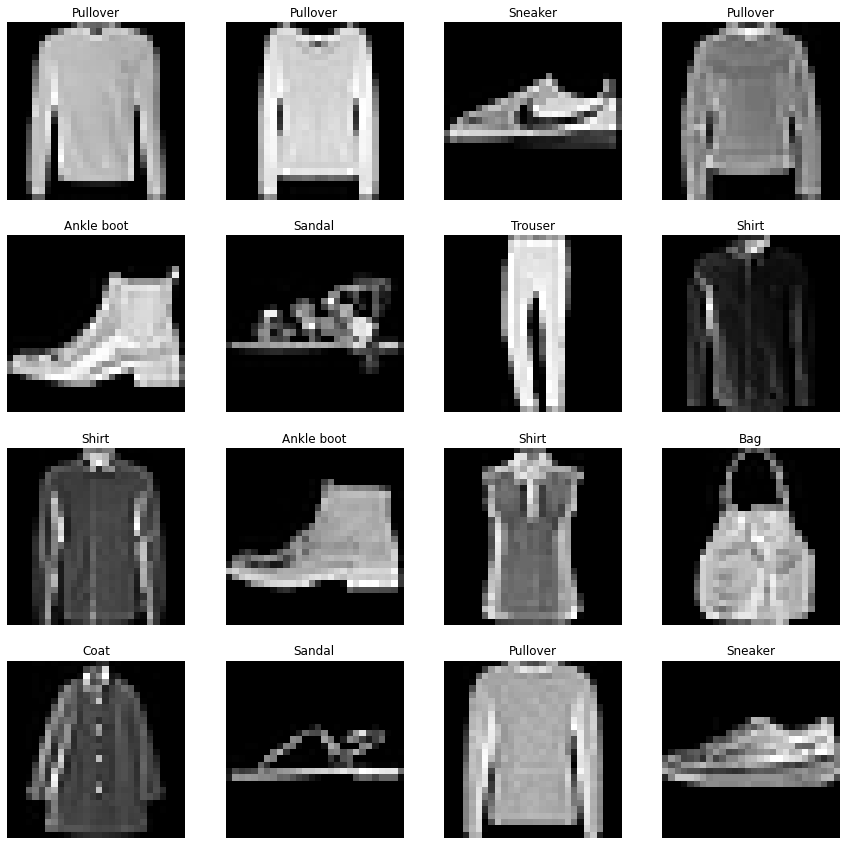

In [134]:
fig, axes = plt.subplots(4, 4, figsize = (15,15))
for row in axes:
    for axe in row:
        index = np.random.randint(60000)
        img = df.drop('label', axis=1).values[index].reshape(28,28)
        cloths = df['label'][index]
        axe.imshow(img, cmap='gray')
        axe.set_title(clothing[cloths])
        axe.set_axis_off()

In [106]:
df['label'].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

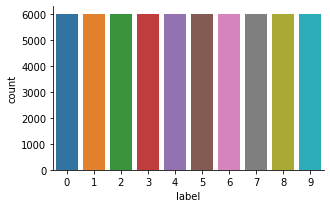

In [107]:
sns.factorplot(x='label', data=df, kind='count', size=3, aspect= 1.5)

In [108]:
seed = 66
np.random.seed(seed)
X = train.iloc[:,1:]
Y = train.iloc[:,0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=seed)

In [110]:
x_train = x_train.to_numpy().reshape((-1, 28, 28, 1))
x_test = x_test.to_numpy().reshape((-1, 28, 28, 1))

In [111]:
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

In [112]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [113]:
print(y_train.shape)
print(y_test.shape)

(54000, 10)
(6000, 10)


In [24]:
# Building a ConvNet
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last', input_shape=(28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
    
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [32]:
# Optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )
# Compiling the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)       

In [34]:
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [35]:
datagen = ImageDataGenerator(
        rotation_range = 8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        shear_range = 0.3,# shear angle in counter-clockwise direction in degrees  
        width_shift_range=0.08,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.08,  # randomly shift images vertically (fraction of total height)
        vertical_flip=True)  # randomly flip images

In [36]:
datagen.fit(x_train)

In [37]:
batch_size = 128
epochs = 40

In [38]:
# Fit the Model
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (x_test, y_test), verbose=2, 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks = [reduce_lr])


Epoch 1/40
 - 255s - loss: 0.8243 - accuracy: 0.7050 - val_loss: 1.5017 - val_accuracy: 0.4953
Epoch 2/40
 - 250s - loss: 0.5451 - accuracy: 0.8001 - val_loss: 0.3470 - val_accuracy: 0.8727
Epoch 3/40
 - 245s - loss: 0.4702 - accuracy: 0.8311 - val_loss: 0.3496 - val_accuracy: 0.8673
Epoch 4/40
 - 233s - loss: 0.4243 - accuracy: 0.8482 - val_loss: 0.3133 - val_accuracy: 0.8817
Epoch 5/40
 - 227s - loss: 0.3963 - accuracy: 0.8587 - val_loss: 0.2808 - val_accuracy: 0.8948
Epoch 6/40
 - 232s - loss: 0.3779 - accuracy: 0.8661 - val_loss: 0.2971 - val_accuracy: 0.8897
Epoch 7/40
 - 228s - loss: 0.3597 - accuracy: 0.8719 - val_loss: 0.2608 - val_accuracy: 0.9043
Epoch 8/40
 - 221s - loss: 0.3476 - accuracy: 0.8758 - val_loss: 0.2441 - val_accuracy: 0.9112
Epoch 9/40
 - 221s - loss: 0.3387 - accuracy: 0.8773 - val_loss: 0.2406 - val_accuracy: 0.9088
Epoch 10/40
 - 219s - loss: 0.3261 - accuracy: 0.8835 - val_loss: 0.2395 - val_accuracy: 0.9127
Epoch 11/40
 - 220s - loss: 0.3186 - accuracy: 0

In [39]:
score = model.evaluate(x_test, y_test)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

6000/6000 [==============================] - 4s 584us/step
Loss: 0.1954
Accuracy: 0.9292


In [40]:
model.save("fashion_model_1.model")

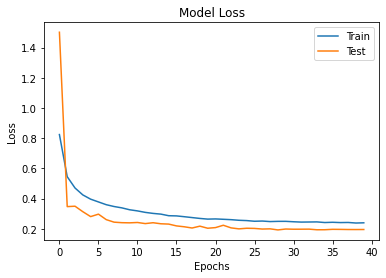

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

In [51]:
#Trail 2





# Let us create a new neural network by applying these above created Dropout Layers to the respecive convolutional Layers 

# Please note that the Dropout layer for all the convolutional layers will be applied after the pooling layer (max. pool layer)
conv1 = Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1) )
conv2 = Conv2D(64, (3,3), activation='relu')
conv3 = Conv2D(128, (3,3), activation='relu')
max_pool_1 = MaxPooling2D((2,2))
max_pool_2 = MaxPooling2D((2,2))
max_pool_3 = MaxPooling2D((2,2))
flat_layer = Flatten()
fc = Dense(128, activation='relu')
drop_1 = Dropout(0.5)
drop_2 = Dropout(0.5)
drop_3 = Dropout(0.5)
output = Dense(10, activation = 'softmax')

model2 = Sequential()

model2.add(conv1)
model2.add(max_pool_2)
model2.add(drop_2)
model2.add(conv3)
model2.add(max_pool_3)
model2.add(drop_3)
model2.add(flat_layer)
model2.add(fc)
model2.add(output)
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 5, 5, 128)        

In [55]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [161]:
model2.fit(x_train, y_train , validation_data = (x_test, y_test), epochs=5, 
              batch_size=128, shuffle=True, verbose = 1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 53s 987us/step - loss: 0.1183 - accuracy: 0.9554 - val_loss: 0.1813 - val_accuracy: 0.9343
Epoch 2/5
54000/54000 [==============================] - 54s 1ms/step - loss: 0.1174 - accuracy: 0.9557 - val_loss: 0.1849 - val_accuracy: 0.9345
Epoch 3/5
54000/54000 [==============================] - 55s 1ms/step - loss: 0.1152 - accuracy: 0.9566 - val_loss: 0.1967 - val_accuracy: 0.9320
Epoch 4/5
54000/54000 [==============================] - 56s 1ms/step - loss: 0.1141 - accuracy: 0.9562 - val_loss: 0.1955 - val_accuracy: 0.9298
Epoch 5/5
54000/54000 [==============================] - 56s 1ms/step - loss: 0.1136 - accuracy: 0.9569 - val_loss: 0.1945 - val_accuracy: 0.9333


In [157]:
model2.save("fashion_model_2.model") #saved the best model

In [162]:
model2.evaluate(x_test,y_test)

6000/6000 [==============================] - 1s 155us/step


[0.1945333444525798, 0.9333333373069763]

In [166]:
from keras.models import load_model
model2 = load_model("fashion_model_2.model")

In [167]:
#Testing 
test = pd.read_csv('Q2_Clothing_test.csv')
df_test = test.copy()
df_test

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,15,...,54,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,155,163,19,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,0


In [168]:
x_t = test.iloc[:,0:]
x_t = x_t.to_numpy().reshape((-1, 28, 28, 1))

In [169]:
x_t = x_t.astype("float32")/255

In [171]:
x_t.shape

(1000, 28, 28, 1)

In [172]:
pre=model2.predict_classes(x_t)

In [175]:
file = open("clothing_submission.txt","w")
for i in pre:
    file.write(str(i)+"\n")

In [176]:
file.close()